In [2]:
import osmnx as ox
import torch
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Dict, Any
import math


from sg_dataset import ArcRoutingDataset, collate_fn
from sg_tester import evaluate_model, predict_routes
from sg_visualizer import plot_truck_routes_comparison, plot_truck_routes_from_model
from sg_model import SequenceRoutingModel
from sg_trainer import train_model
from sg_tester import compute_summary_metrics
# from sg_post_processer import post_process_routes
from sg_trainer import get_dataloaders

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the full-city graph from OSMnx
print("Loading street graph for Tartu, Estonia…")
G = ox.graph_from_place("Tartu, Estonia", network_type="drive")
print(f"Graph loaded: {len(G.nodes)} nodes, {len(G.edges)} edges")

Loading street graph for Tartu, Estonia…
Graph loaded: 2263 nodes, 5582 edges


In [5]:
CSV_FILE = "v2_ground_truth_samples.csv"

model, train_loader, test_loader = train_model(
    csv_file      = CSV_FILE,
    main_graph    = G,
    node_in_dim   = 5,
    gnn_hid       = 64,
    gnn_out       = 128,
    assign_hid    = 128,
    ptr_hid       = 256,
    seq_len       = 50,
    num_heads     = 8,
    num_layers    = 3,
    dropout       = 0.05,
    max_trucks    = 10,
    batch_size    = 8,
    lr         = 1e-3,
    epochs  = 100,
    lambda_cov    = 1.0,
    device        = DEVICE
    )

In [4]:
evaluate_model(model, test_loader, G, device=DEVICE)


=== Detailed Per‐Sample / Per‐Truck Comparison ===

--- Sample 0 ---
Truck 0:
   GT   : [330043471, 330044651, 330044640, 330044651, 330044660, 330044651, 330043471]
   Pred : [330043471, 330044651, 330044640, 330044664, 330041573, 330041568, 330044640, 330044651, 330043471]

Truck 1:
   GT   : [330043515, 330041571, 330041568, 330041573, 330041552, 330041573, 330044664, 330041573, 330041568, 330044640, 330044664, 330044640, 330041568, 330041571, 330041548, 330040670, 330043515, 330040670, 330041548, 330041571, 330042421, 330043471, 330042421, 330041571, 330043515]
   Pred : [330043515, 330041571, 330041568, 330044640, 330044664, 330041573, 330041568, 330041571, 330043515]

Sample 0 coverage: 0.5333 (8/15 task‐edges covered)

--- Sample 1 ---
Truck 0:
   GT   : [3868757235, 330044213, 330043489, 330043148, 330043489, 2139961795, 330043489, 330045303, 330043489, 330044213, 3868757235]
   Pred : [3868757235, 330044213, 330043489, 330045303, 330045308, 330045303, 330043489, 330044213, 38

In [5]:
torch.save(model.state_dict(), "v2_supervised_routing_model.pt")

In [6]:
#load model
device = DEVICE
model = SequenceRoutingModel(
    node_in_dim=5,
    gnn_hid=64,
    gnn_out=128,
    assign_hid=128,
    ptr_hid=256,
    seq_len=50,
    num_heads=8,
    num_layers=3,
    max_trucks=10,
    dropout=0.05
).to(device)

ckpt = torch.load("v2_supervised_routing_model.pt", map_location=device)
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    model.load_state_dict(ckpt["model_state_dict"])
else:
    model.load_state_dict(ckpt)

model.eval()

SequenceRoutingModel(
  (encoder): GraphEncoder(
    (edge_mlp1): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=320, bias=True)
    )
    (edge_mlp2): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=8192, bias=True)
    )
    (conv1): NNConv(5, 64, aggr=mean, nn=Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=320, bias=True)
    ))
    (conv2): NNConv(64, 128, aggr=mean, nn=Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=8192, bias=True)
    ))
    (act): ReLU()
  )
  (assigner_line): EdgeAssignmentLineGNN(
    (convs): ModuleList(
      (0): GraphConv(11, 128)
      (1-2): 2 x GraphConv(128, 128)
    )
    (act): ReLU()
    (drop

In [7]:
import torch
import networkx as nx
from typing import List, Dict, Any

def post_process_routes(test_loader, model: SequenceRoutingModel, main_graph: nx.Graph) -> List[Dict[str, Any]]:
    """
    For each sample in test_loader:
      - run model to get initial predicted routes
      - identify task-edges not covered by any truck
      - for each missing edge (u,v), greedily insert it where it causes the
        minimal extra distance across all trucks & positions
      - preserve your original debug prints for missing nodes

    Returns a list of dicts per sample with keys:
      'raw_nodes'       : List[node_id]
      'list_edges'      : List[tuple(u,v)]
      'gt_routes'       : List[List[node_id]]  # ground‐truth in node IDs
      'pred_routes'     : List[List[node_id]]  # initial predictions in node IDs
      'uncovered_edges' : List[tuple(u,v)]
      'post_routes'     : List[List[node_id]]  # after insertion, node IDs
      'insertions'      : List[dict]           # insertion metadata
    """
    model.eval()
    device = next(model.parameters()).device

    # helper: shortest-path distance in main_graph, ∞ if missing
    def sp_dist(u: Any, v: Any) -> float:
        if u not in main_graph or v not in main_graph:
            return float('inf')
        try:
            return nx.shortest_path_length(main_graph, u, v, weight='length')
        except nx.NetworkXNoPath:
            return float('inf')

    all_results: List[Dict[str, Any]] = []

    for batch in test_loader:
        # unpack batch
        raw_nodes_list   = batch["raw_list_nodes"]    # List[List[node_id]]
        list_edges_list  = batch["list_edges"]        # List[List[(u,v)]]
        pointer_tgts     = batch["pointer_targets"]   # List[List[LongTensor]]
        BG               = batch["batch_graph"].to(device)
        LG               = batch["batch_line_graph"].to(device)
        deps             = batch["depot_indices"].to(device)

        B = len(raw_nodes_list)

        # 1) edge→truck assignment
        with torch.no_grad():
            lg_logits    = model.assigner_line(LG)           # (sum_E, M)
            assigns_flat = lg_logits.argmax(dim=1)           # (sum_E,)
        edge_assigns: List[torch.Tensor] = []
        offset = 0
        for edges in list_edges_list:
            E = len(edges)
            edge_assigns.append(assigns_flat[offset:offset+E])
            offset += E

        # 2) build task‐only return subgraphs
        return_subgraphs: List[nx.Graph] = []
        for nodes, edges in zip(raw_nodes_list, list_edges_list):
            G_task = nx.Graph()
            G_task.add_nodes_from(nodes)
            for u, v in edges:
                if main_graph.has_edge(u, v):
                    attr = main_graph.get_edge_data(u, v)
                    if isinstance(attr, dict) and 0 in attr:
                        attr = attr[0]
                    length = attr.get("length", 1.0)
                else:
                    length = 1.0
                G_task.add_edge(u, v, length=length)
            return_subgraphs.append(G_task)

        # 3) encode
        with torch.no_grad():
            node_emb, global_emb, batch_vec = model.encoder(BG)

        # 4) greedy decode
        with torch.no_grad():
            routes_idx = model.decoder(
                global_emb,
                node_emb,
                batch_vec,
                deps,
                raw_nodes_list,
                list_edges_list,
                return_subgraphs,
                edge_assigns,
                use_teacher_forcing=False
            )  # List[B] of List[M] of index‐sequences

        # 5) for each sample, post‐process
        for i in range(B):
            raw_nodes   = raw_nodes_list[i]      # node IDs
            task_edges  = list_edges_list[i]     # (u,v) node IDs
            ptr_tgts_i  = pointer_tgts[i]        # List[LongTensor] length M
            pred_idx_seqs = routes_idx[i]        # List[List[index]]

            # 5a) build ground‐truth routes in node IDs
            eos_idx = len(raw_nodes)
            gt_routes: List[List[Any]] = []
            for tgt in ptr_tgts_i:
                seq = []
                for idx in tgt.tolist():
                    if idx == eos_idx:
                        break
                    # safety check
                    if 0 <= idx < eos_idx:
                        seq.append(raw_nodes[idx])
                gt_routes.append(seq)

            # 5b) map pred indices → node IDs
            pred_routes: List[List[Any]] = []
            for seq in pred_idx_seqs:
                pred_routes.append([ raw_nodes[idx] for idx in seq ])

            # 5c) compute covered & missing
            service_set = set(task_edges)
            covered = set()
            for route in pred_routes:
                for a, b in zip(route, route[1:]):
                    covered.add((a, b))
            missing = [ tuple(e) for e in (service_set - covered) ]

            # 5d) post‐process copy
            post_routes = [ list(r) for r in pred_routes ]
            insertions: List[Dict[str, Any]] = []

            for edge in missing:
                if not isinstance(edge, (list, tuple)) or len(edge) != 2:
                    # skip malformed
                    continue
                u, v = edge
                # original debug
                if u not in main_graph:
                    print(f"DEBUG: node {u} not in main_graph nodes (sample raw_nodes: {raw_nodes[:10]}...)")
                if v not in main_graph:
                    print(f"DEBUG: node {v} not in main_graph nodes")

                L_uv = sp_dist(u, v)
                best = {'truck':None, 'pos':None, 'extra':float('inf'), 'orient':(u, v)}

                for t_idx, route in enumerate(post_routes):
                    for p in range(len(route)-1):
                        a, b = route[p], route[p+1]
                        d_ab = sp_dist(a, b)

                        # try u→v
                        extra_uv = (sp_dist(a, u) + L_uv + sp_dist(v, b)) - d_ab
                        if extra_uv < best['extra']:
                            best.update(truck=t_idx, pos=p+1,
                                        extra=extra_uv, orient=(u, v))
                        # try v→u
                        extra_vu = (sp_dist(a, v) + L_uv + sp_dist(u, b)) - d_ab
                        if extra_vu < best['extra']:
                            best.update(truck=t_idx, pos=p+1,
                                        extra=extra_vu, orient=(v, u))

                t, p = best['truck'], best['pos']
                if t is not None:
                    x, y = best['orient']
                    post_routes[t].insert(p, x)
                    post_routes[t].insert(p+1, y)
                    insertions.append({
                        'edge':        (u, v),
                        'truck':       t,
                        'position':    p,
                        'orientation': (x, y),
                        'extra_cost':  best['extra']
                    })

            all_results.append({
                'raw_nodes':       raw_nodes,
                'list_edges':      task_edges,
                'gt_routes':       gt_routes,
                'pred_routes':     pred_routes,
                'uncovered_edges': missing,
                'post_routes':     post_routes,
                'insertions':      insertions
            })

    return all_results

In [8]:
CSV_FILE = "v2_ground_truth_samples.csv"

train_loader, test_loader = get_dataloaders(
    csv_file = CSV_FILE,
    main_graph = G,
    batch_size =8,
    pointer_seq_len = 50,
    max_trucks=10
)

In [8]:
results = post_process_routes(test_loader, model, G)

In [9]:
all_results = post_process_routes(test_loader, model, G)
df = compute_metrics_df(all_results, G)
df

,sample_idx,pred_truck_dists,pred_total_deadhead,pred_max_dist,gt_total_deadhead,gt_max_dist,coverage_before,coverage_after,gt_total_distance,pred_total_distance,deadhead_ratio,workload_cv,gt_workload_cv,gt_deadhead_ratio
0,0,"[1305.0199179284475, 875.7714975421233, 665.29...",3508.415132,1305.019918,0.0,2751.449214,46.666667,80.000000,3194.880606,4967.945254,1.098137,0.663893,2.570873,0.0
1,1,"[1489.8544643233904, 836.5444649972518, 227.81...",2660.056621,1489.854464,0.0,1124.178392,57.142857,100.000000,1483.854464,4148.911085,1.792667,0.968113,2.308079,0.0
2,2,"[911.1062429704207, 1255.761823985435, 156.311...",2507.454678,1255.761824,0.0,2472.722425,30.769231,73.076923,2679.209879,3417.358392,0.935893,1.108377,2.752706,0.0
3,3,"[467.11627521042965, 297.31248210523677, 213.1...",626.036333,467.116275,0.0,734.419060,77.777778,77.777778,1244.928197,1465.852379,0.502869,0.892675,1.828600,0.0
4,4,"[1150.2304234375445, 546.3083490442108, 240.33...",2374.181594,1150.230423,0.0,1392.474828,50.000000,83.333333,2130.005086,3619.254054,1.114637,0.768535,2.114884,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,"[311.8189740902002, 1487.9186215458508, 179.54...",1860.307393,1487.918622,0.0,1123.083726,55.555556,83.333333,2060.074779,3236.066532,0.903029,1.205484,2.010174,0.0
110,110,"[926.7124516562976, 873.7085896630524, 197.445...",2255.823796,926.712452,0.0,611.978841,83.333333,100.000000,1122.157481,3379.981277,2.010256,0.832419,2.010261,0.0
111,111,"[575.1627918258552, 566.2059428835975, 177.498...",1420.988446,575.162792,0.0,573.162792,66.666667,100.000000,1137.368735,2561.357181,1.249365,0.614077,2.000078,0.0
112,112,"[909.5265586724653, 1222.7760683437962, 102.35...",1841.017183,1222.776068,0.0,1905.194252,55.555556,77.777778,2068.970062,2951.124803,0.889823,1.327734,2.746299,0.0


In [10]:
import pandas as pd
import math

def compute_metrics_df(all_results, main_graph):
    """
    Compute per‐sample and per‐truck distance & deadhead metrics.

    Returns a pandas DataFrame with columns:
      - sample_idx
      - pred_truck_dists: list of distances per truck (post-processed)
      - pred_total_deadhead: total deadhead + missed-edge length
      - pred_max_dist: longest single‐truck distance predicted
      - gt_total_deadhead: total deadhead distance ground truth
      - gt_max_dist: longest single‐truck distance ground truth
      - pct_diff_deadhead: % difference in deadhead (pred vs gt)
      - coverage_before: % of list_edges covered by res['pred_routes']
      - coverage_after: % of list_edges covered by res['post_routes']
      - gt_total_distance: sum of all gt route distances
      - pred_total_distance: sum of all post-processed route distances
      - deadhead_ratio: pred_total_deadhead / sum of lengths(list_edges)
      - workload_cv: coefficient of variation of post-processed truck distances
      - gt_workload_cv: coefficient of variation of ground-truth truck distances
      - gt_deadhead_ratio: gt_total_deadhead / sum of lengths(list_edges)
    """
    rows = []

    def length(u, v):
        data = main_graph.get_edge_data(u, v) or main_graph.get_edge_data(v, u) or {}
        if isinstance(data, dict) and 0 in data:
            data = data[0]
        return data.get('length', 1.0)

    for idx, res in enumerate(all_results):
        list_edges  = res.get('list_edges', [])
        post_routes = res.get('post_routes', [])
        pred_routes = res.get('pred_routes', [])
        gt_routes   = res.get('gt_routes', [])

        # total length of service edges
        total_service_length = sum(length(u, v) for u, v in list_edges)

        # --- Coverage metrics ---
        def coverage(routes):
            seen = {(u, v) for route in routes for u, v in zip(route, route[1:])}
            if not list_edges:
                return None
            return sum(1 for e in list_edges if e in seen) / len(list_edges) * 100.0

        coverage_before = coverage(pred_routes)
        coverage_after  = coverage(post_routes)

        # --- Predicted (post-processed) metrics ---
        pred_truck_dists = []
        freq_pred = {}
        for route in post_routes:
            d = 0.0
            for u, v in zip(route, route[1:]):
                d += length(u, v)
                freq_pred[(u, v)] = freq_pred.get((u, v), 0) + 1
            pred_truck_dists.append(d)

        # base deadhead = extra traversals
        pred_total_deadhead = sum(
            (cnt - 1) * length(u, v)
            for (u, v), cnt in freq_pred.items() if cnt > 1
        )
        # add missed service edges
        covered = set(freq_pred.keys())
        missed_length = sum(
            length(u, v)
            for (u, v) in list_edges
            if (u, v) not in covered
        )
        pred_total_deadhead += missed_length

        pred_total_distance = sum(pred_truck_dists)
        pred_max_dist       = max(pred_truck_dists) if pred_truck_dists else 0.0
        deadhead_ratio = (
            pred_total_deadhead / total_service_length
            if total_service_length > 0 else None
        )

        # workload CV
        if len(pred_truck_dists) > 1:
            mean_p = pred_total_distance / len(pred_truck_dists)
            var_p  = sum((d - mean_p)**2 for d in pred_truck_dists) / len(pred_truck_dists)
            workload_cv = math.sqrt(var_p) / mean_p if mean_p > 0 else None
        else:
            workload_cv = None

        # --- Ground‐truth metrics ---
        gt_truck_dists = []
        freq_gt = {}
        for route in gt_routes:
            d = 0.0
            for u, v in zip(route, route[1:]):
                d += length(u, v)
                freq_gt[(u, v)] = freq_gt.get((u, v), 0) + 1
            gt_truck_dists.append(d)

        gt_total_deadhead  = sum(
            (cnt - 1) * length(u, v)
            for (u, v), cnt in freq_gt.items() if cnt > 1
        )
        gt_total_distance  = sum(gt_truck_dists)
        gt_max_dist        = max(gt_truck_dists) if gt_truck_dists else 0.0
        gt_deadhead_ratio  = (
            gt_total_deadhead / total_service_length
            if total_service_length > 0 else None
        )

        # gt workload CV
        if len(gt_truck_dists) > 1:
            mean_g = gt_total_distance / len(gt_truck_dists)
            var_g  = sum((d - mean_g)**2 for d in gt_truck_dists) / len(gt_truck_dists)
            gt_workload_cv = math.sqrt(var_g) / mean_g if mean_g > 0 else None
        else:
            gt_workload_cv = None

        # pct diff deadhead
        pct_diff_deadhead = (
            (pred_total_deadhead - gt_total_deadhead) / gt_total_deadhead * 100.0
            if gt_total_deadhead != 0 else None
        )

        rows.append({
            'sample_idx':            idx,
            'pred_truck_dists':      pred_truck_dists,
            'pred_total_deadhead':   pred_total_deadhead,
            'pred_max_dist':         pred_max_dist,
            'gt_total_deadhead':     gt_total_deadhead,
            'gt_max_dist':           gt_max_dist,
            # 'pct_diff_deadhead':     pct_diff_deadhead,
            'coverage_before':       coverage_before,
            'coverage_after':        coverage_after,
            'gt_total_distance':     gt_total_distance,
            'pred_total_distance':   pred_total_distance,
            'deadhead_ratio':        deadhead_ratio,
            'workload_cv':           workload_cv,
            'gt_workload_cv':        gt_workload_cv,
            'gt_deadhead_ratio':     gt_deadhead_ratio,
        })

    return pd.DataFrame(rows)


In [11]:
df.to_csv('final_supervised_df_2.csv', index=False)

In [34]:
import csv

file_path = 'final_supervised_all_results.csv'

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(all_results)

In [16]:
display(df.loc[0])
print("\n")
display(df.loc[2])
print("\n")
display(df.loc[3])
print("\n")
display(df.loc[4])
print("\n")
display(df.loc[9])
print("\n")
display(df.loc[97])
print("\n")
display(df.loc[98])
print("\n")
display(df.loc[104])
print("\n")
display(df.loc[107])

# 0, 2, 3, 4, 9, 97, 98, 104, 107, 

sample_idx                                                             0
pred_truck_dists       [1305.0199179284475, 875.7714975421233, 665.29...
pred_total_deadhead                                          3508.415132
pred_max_dist                                                1305.019918
gt_total_deadhead                                                    0.0
gt_max_dist                                                  2751.449214
coverage_before                                                46.666667
coverage_after                                                      80.0
gt_total_distance                                            3194.880606
pred_total_distance                                          4967.945254
deadhead_ratio                                                  1.098137
workload_cv                                                     0.663893
gt_workload_cv                                                  2.570873
gt_deadhead_ratio                                  

sample_idx                                                             2
pred_truck_dists       [911.1062429704207, 1255.761823985435, 156.311...
pred_total_deadhead                                          2507.454678
pred_max_dist                                                1255.761824
gt_total_deadhead                                                    0.0
gt_max_dist                                                  2472.722425
coverage_before                                                30.769231
coverage_after                                                 73.076923
gt_total_distance                                            2679.209879
pred_total_distance                                          3417.358392
deadhead_ratio                                                  0.935893
workload_cv                                                     1.108377
gt_workload_cv                                                  2.752706
gt_deadhead_ratio                                  

sample_idx                                                             3
pred_truck_dists       [467.11627521042965, 297.31248210523677, 213.1...
pred_total_deadhead                                           626.036333
pred_max_dist                                                 467.116275
gt_total_deadhead                                                    0.0
gt_max_dist                                                    734.41906
coverage_before                                                77.777778
coverage_after                                                 77.777778
gt_total_distance                                            1244.928197
pred_total_distance                                          1465.852379
deadhead_ratio                                                  0.502869
workload_cv                                                     0.892675
gt_workload_cv                                                    1.8286
gt_deadhead_ratio                                  

sample_idx                                                             4
pred_truck_dists       [1150.2304234375445, 546.3083490442108, 240.33...
pred_total_deadhead                                          2374.181594
pred_max_dist                                                1150.230423
gt_total_deadhead                                                    0.0
gt_max_dist                                                  1392.474828
coverage_before                                                     50.0
coverage_after                                                 83.333333
gt_total_distance                                            2130.005086
pred_total_distance                                          3619.254054
deadhead_ratio                                                  1.114637
workload_cv                                                     0.768535
gt_workload_cv                                                  2.114884
gt_deadhead_ratio                                  

sample_idx                                                             9
pred_truck_dists       [1631.5502562531601, 881.4930288082459, 198.11...
pred_total_deadhead                                          2865.654763
pred_max_dist                                                1631.550256
gt_total_deadhead                                                    0.0
gt_max_dist                                                  1661.732621
coverage_before                                                60.714286
coverage_after                                                      75.0
gt_total_distance                                            2946.731124
pred_total_distance                                          4097.941534
deadhead_ratio                                                  0.972486
workload_cv                                                     1.111228
gt_workload_cv                                                  2.020328
gt_deadhead_ratio                                  

sample_idx                                                            97
pred_truck_dists       [929.8857387651078, 590.3728887546356, 557.675...
pred_total_deadhead                                          1339.269943
pred_max_dist                                                 929.885739
gt_total_deadhead                                                    0.0
gt_max_dist                                                  1177.866698
coverage_before                                                66.666667
coverage_after                                                 94.444444
gt_total_distance                                            1691.310731
pred_total_distance                                          2842.841535
deadhead_ratio                                                  0.791853
workload_cv                                                     0.994704
gt_workload_cv                                                  2.184407
gt_deadhead_ratio                                  

sample_idx                                                            98
pred_truck_dists       [292.9399255200689, 100.74554286233419, 545.15...
pred_total_deadhead                                           644.380878
pred_max_dist                                                 545.152478
gt_total_deadhead                                                    0.0
gt_max_dist                                                  1026.711618
coverage_before                                                41.666667
coverage_after                                                 70.833333
gt_total_distance                                            1288.533326
pred_total_distance                                          1000.032359
deadhead_ratio                                                  0.500089
workload_cv                                                     1.713663
gt_workload_cv                                                  2.394834
gt_deadhead_ratio                                  

sample_idx                                                           104
pred_truck_dists       [649.8544580993859, 417.3064039761244, 249.337...
pred_total_deadhead                                          2129.774479
pred_max_dist                                                 649.854458
gt_total_deadhead                                                    0.0
gt_max_dist                                                   771.585606
coverage_before                                                     87.5
coverage_after                                                     100.0
gt_total_distance                                             930.084969
pred_total_distance                                          3061.859448
deadhead_ratio                                                  2.289871
workload_cv                                                     0.408327
gt_workload_cv                                                   2.48446
gt_deadhead_ratio                                  

sample_idx                                                           107
pred_truck_dists       [418.2127317953155, 510.18548454966754, 1285.4...
pred_total_deadhead                                           570.015538
pred_max_dist                                                1285.430859
gt_total_deadhead                                                    0.0
gt_max_dist                                                  2035.206561
coverage_before                                                     20.0
coverage_after                                                      80.0
gt_total_distance                                            2545.392046
pred_total_distance                                          2436.023738
deadhead_ratio                                                   0.22394
workload_cv                                                     1.590491
gt_workload_cv                                                  2.407236
gt_deadhead_ratio                                  

In [ ]:
df.loc[89]

In [14]:
column_means = df.mean(numeric_only=True)

In [15]:
column_means 

sample_idx               56.500000
pred_total_deadhead    1893.138383
pred_max_dist           921.263196
gt_total_deadhead         2.137720
gt_max_dist            1116.786900
coverage_before          65.642071
coverage_after           85.800145
gt_total_distance      1570.612933
pred_total_distance    2897.378217
deadhead_ratio            1.468105
workload_cv               0.902750
gt_workload_cv            2.253507
gt_deadhead_ratio         0.001980
dtype: float64

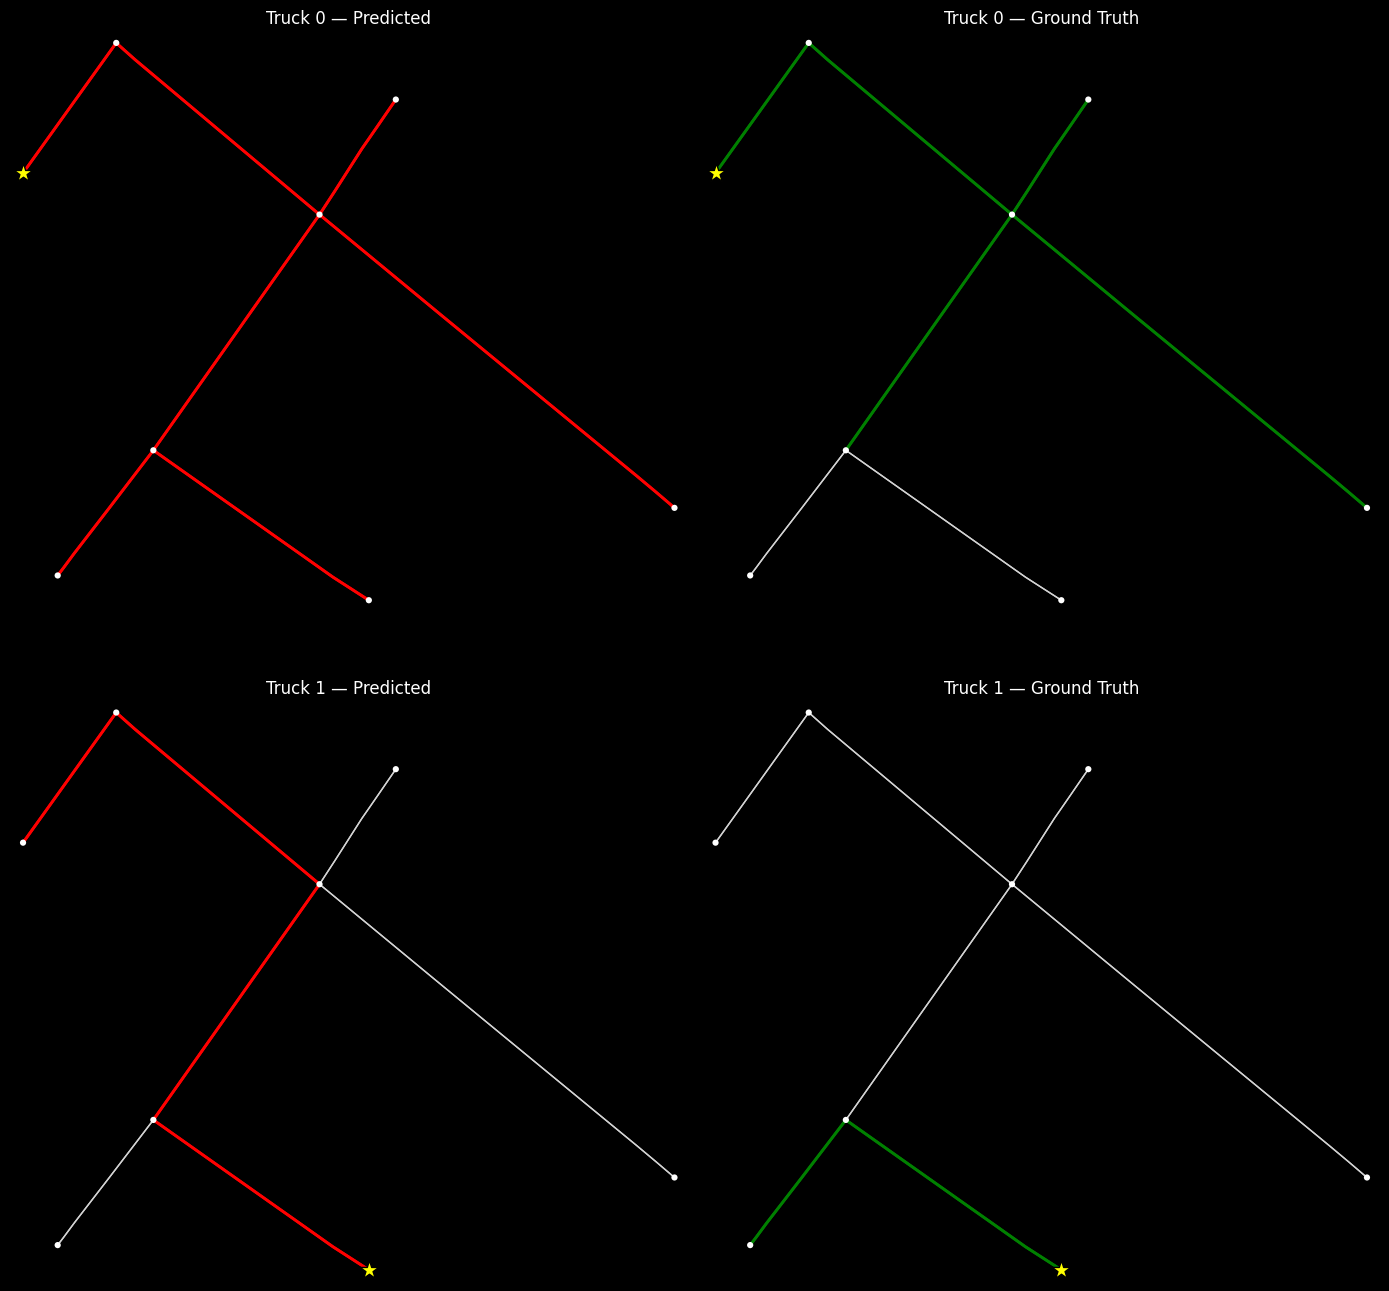

In [18]:
i = 1

res   = all_results[i]
edges = res['list_edges']     
preds = res['post_routes']    
gts   = res['gt_routes']

num_trucks = sum(1 for gt in gts if len(gt) > 0)

sample = test_loader.dataset[i]
raw    = sample['raw_list_nodes']
deps   = sample['depot_indices'].tolist()
depots = { t: raw[d] for t, d in enumerate(deps) }

# routes
pred_dict = { t: preds[t] for t in range(num_trucks) }
gt_dict   = { t: gts[t]   for t in range(num_trucks) }

plot_truck_routes_comparison(
    graph           = G,
    task_edges      = edges,
    pred_route_dict = pred_dict,
    gt_route_dict   = gt_dict,
    depots          = depots
)

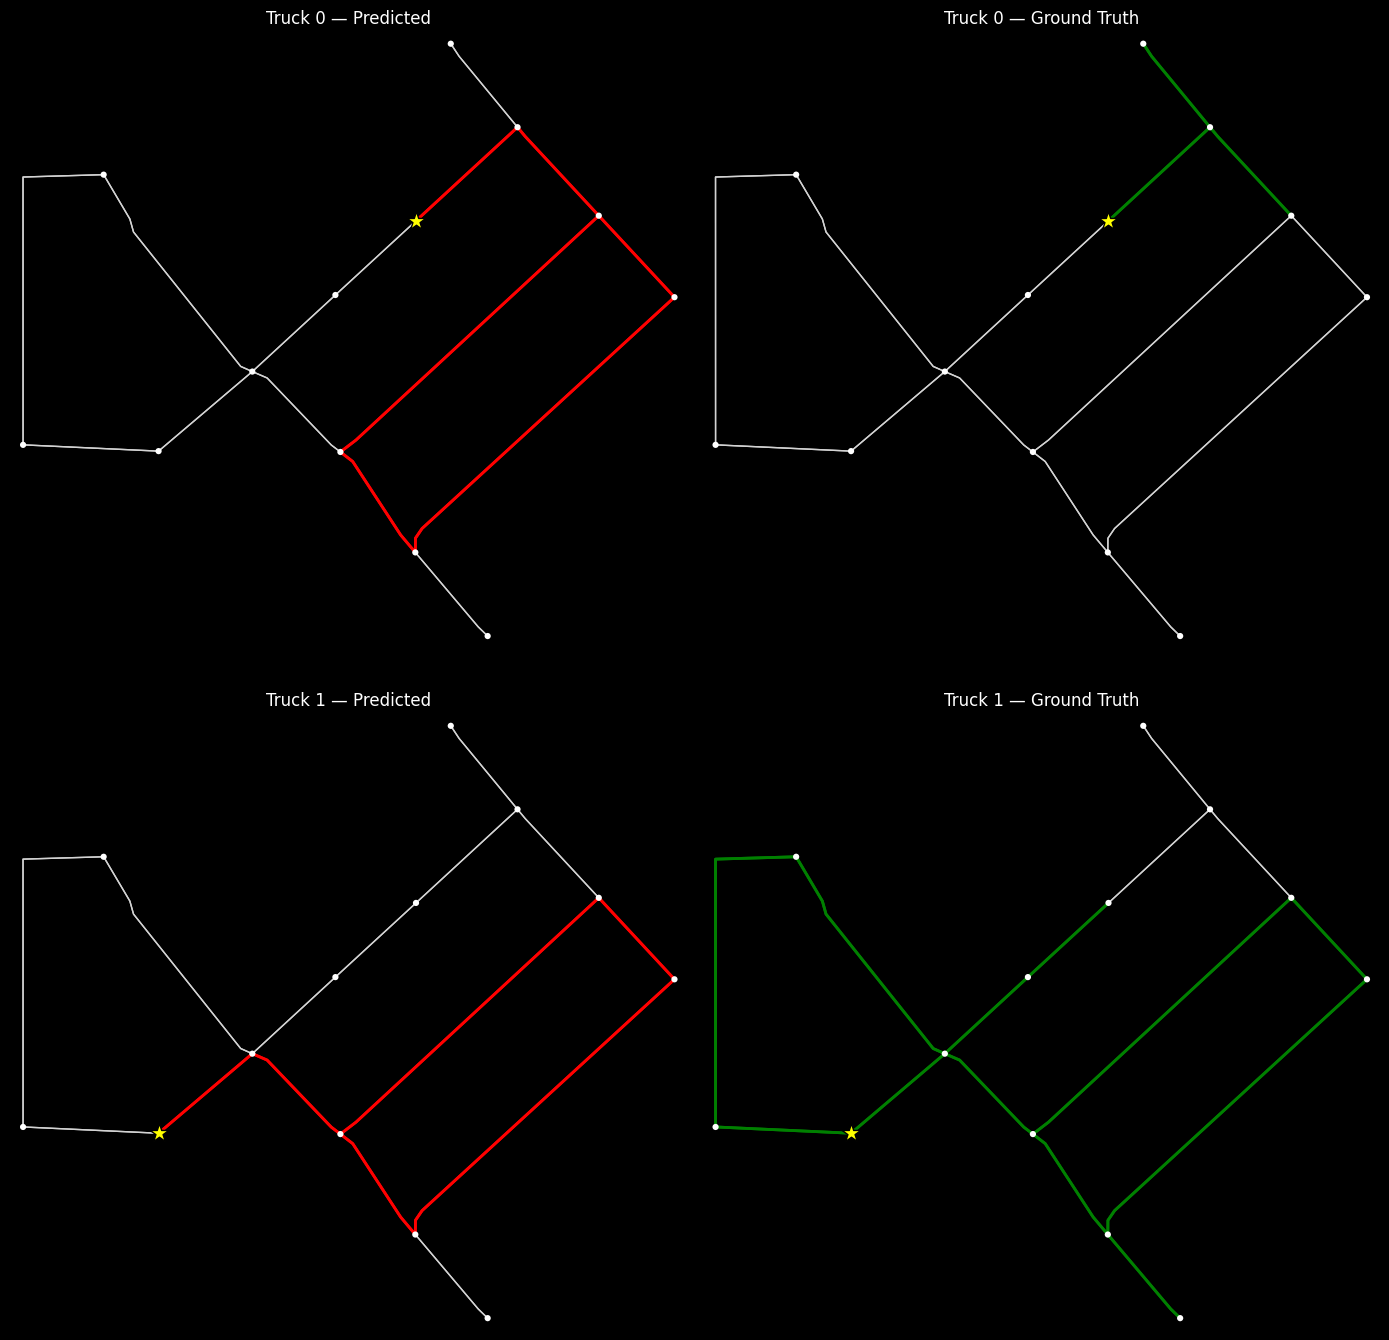

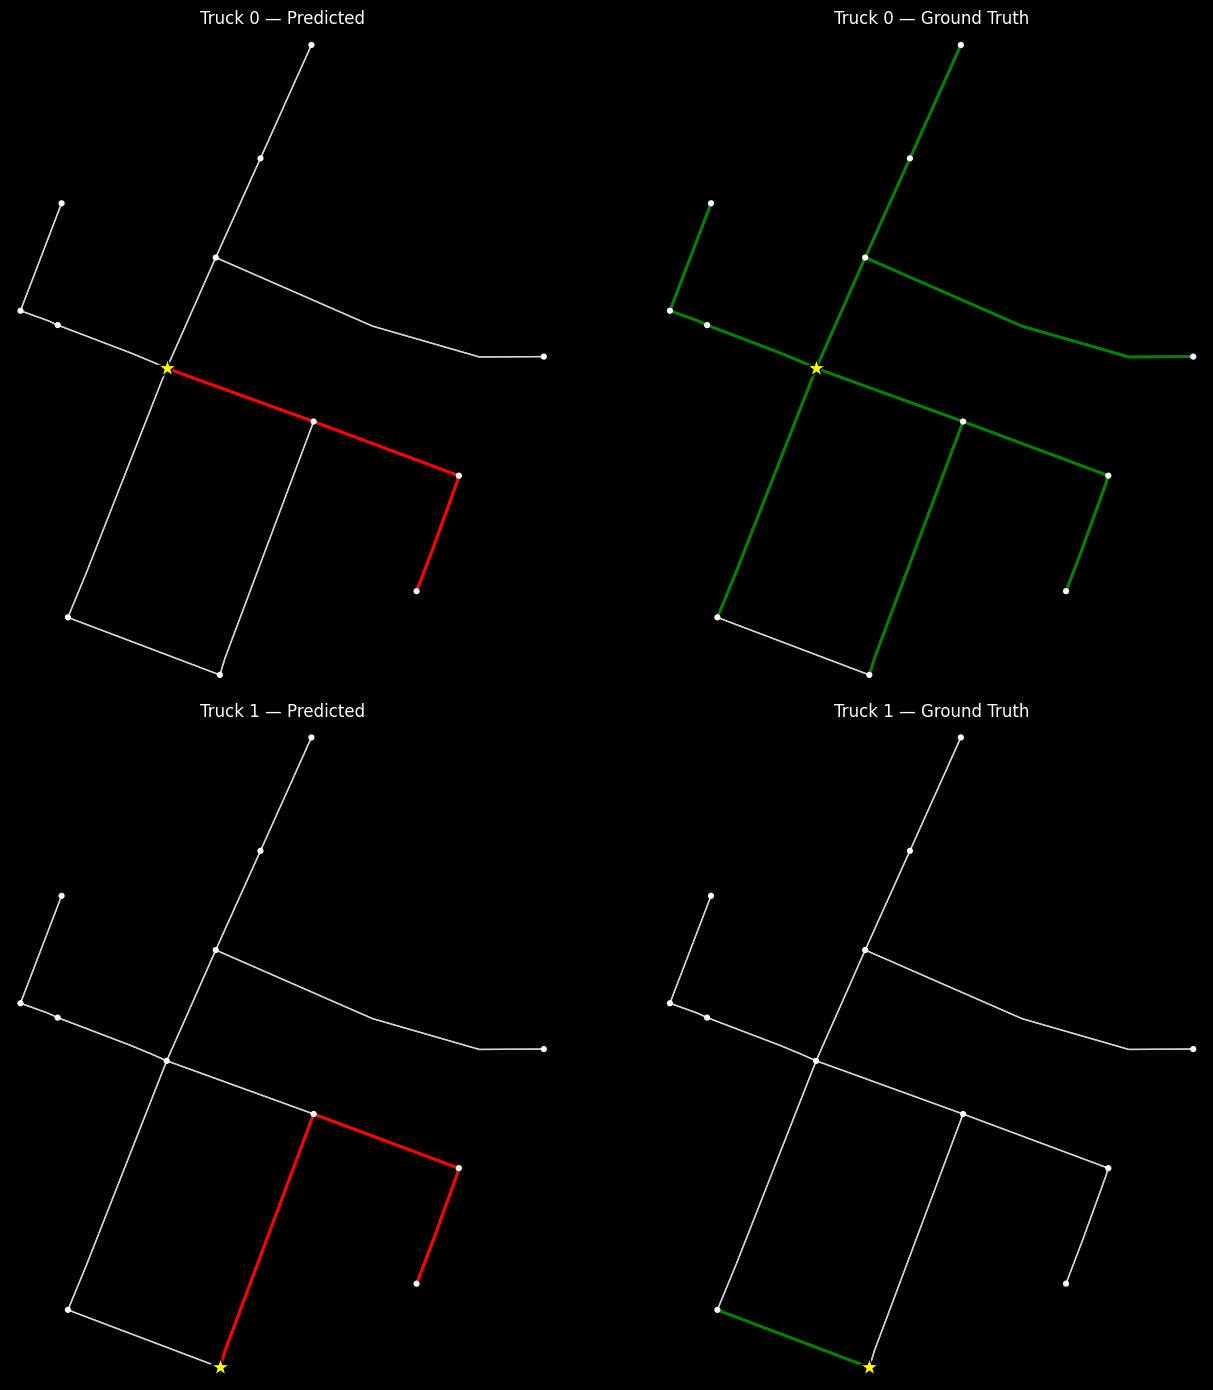

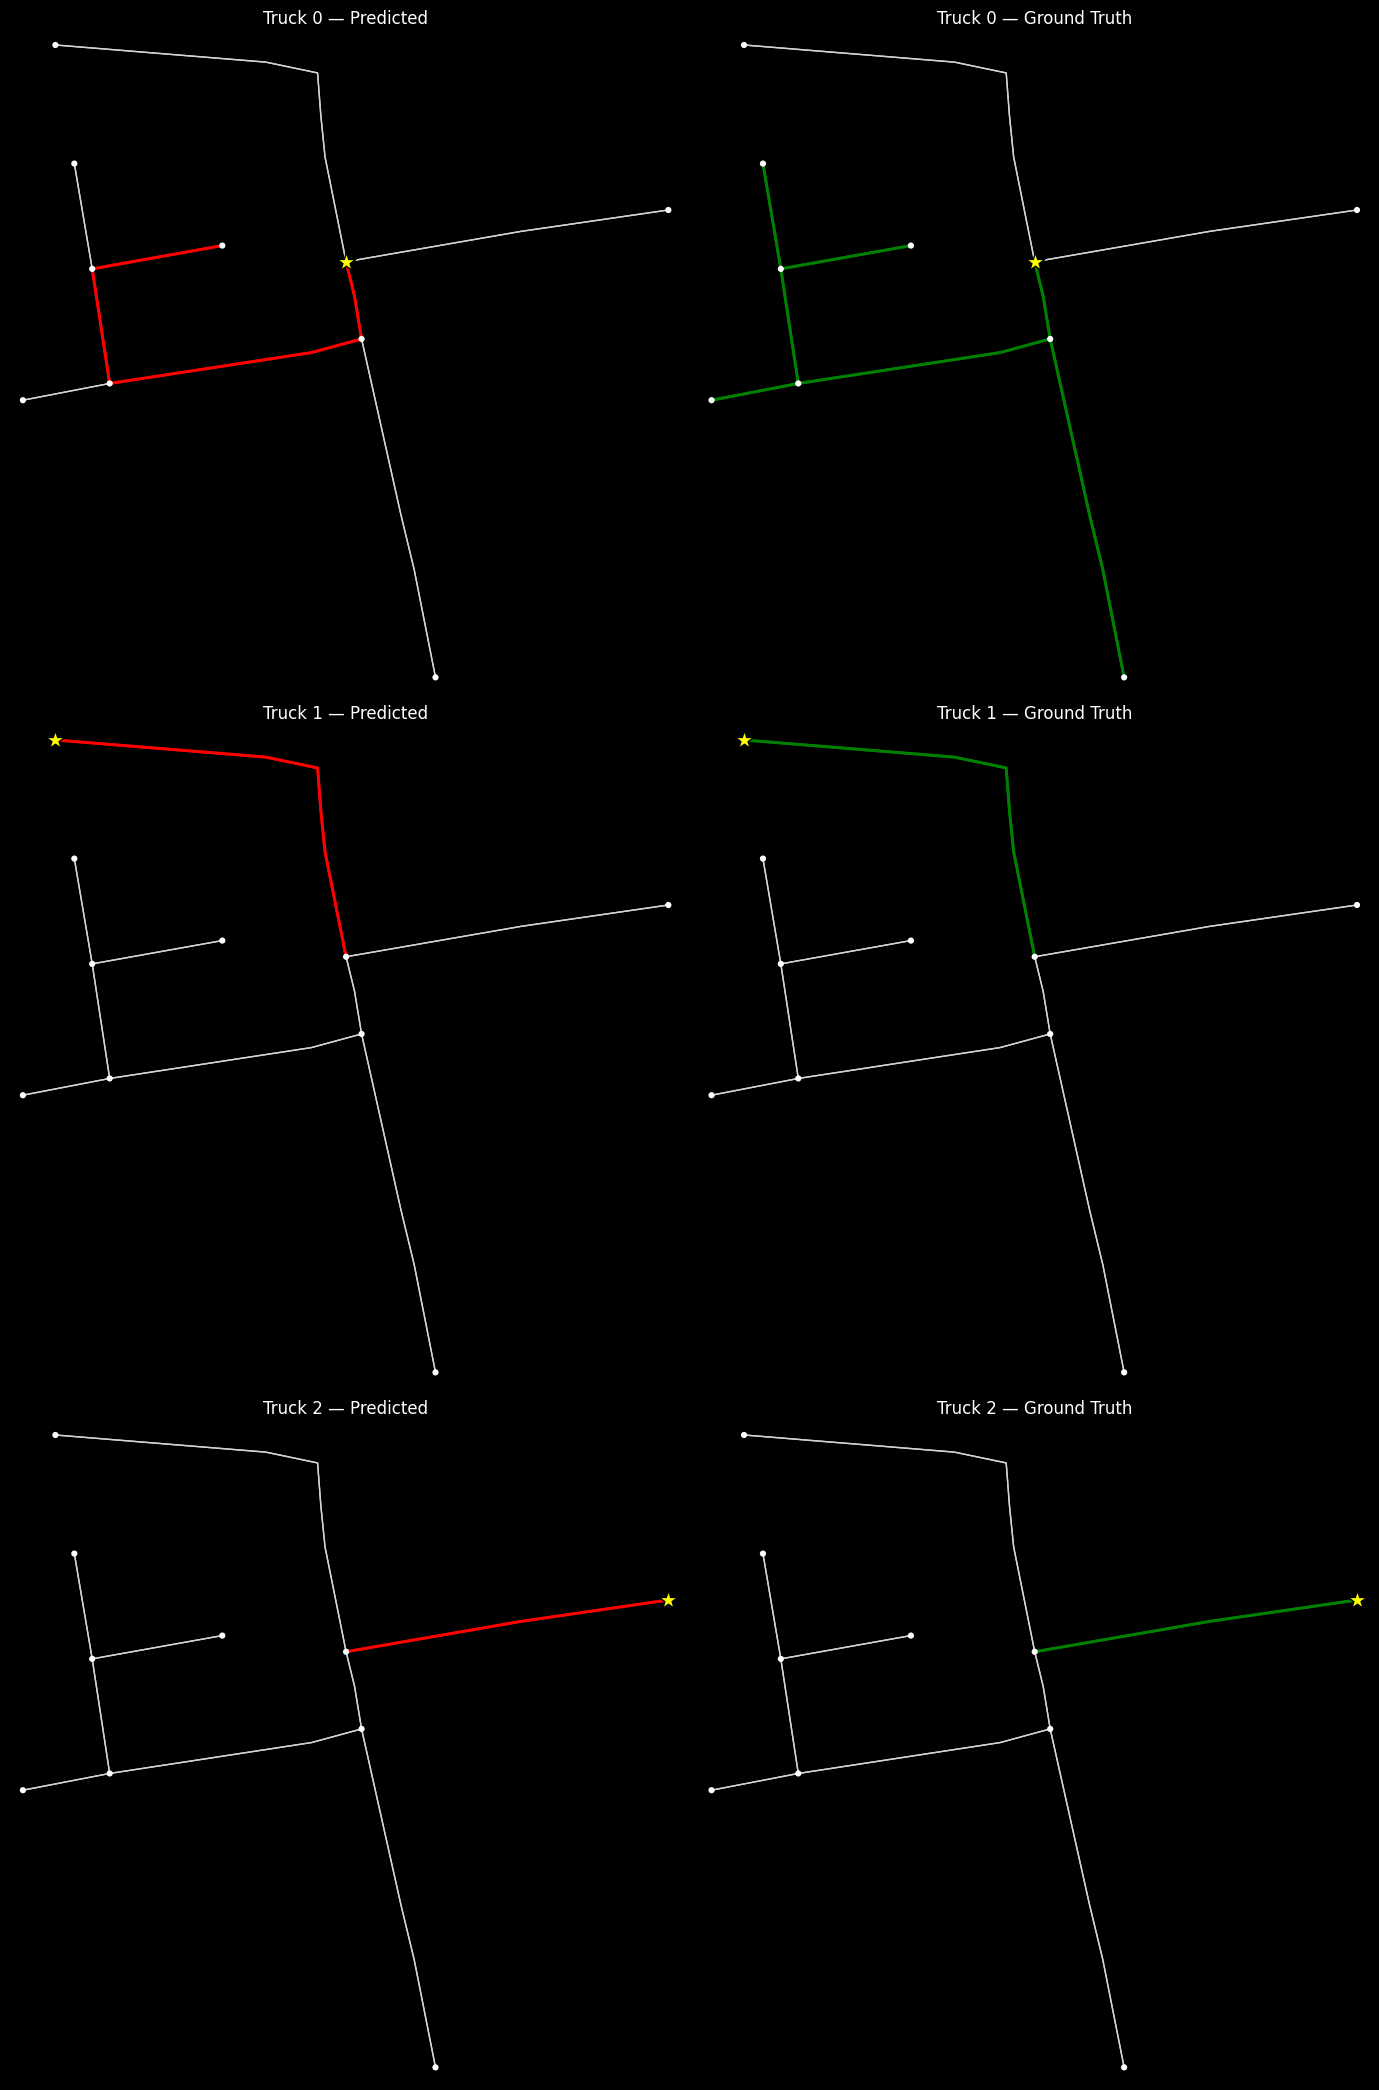

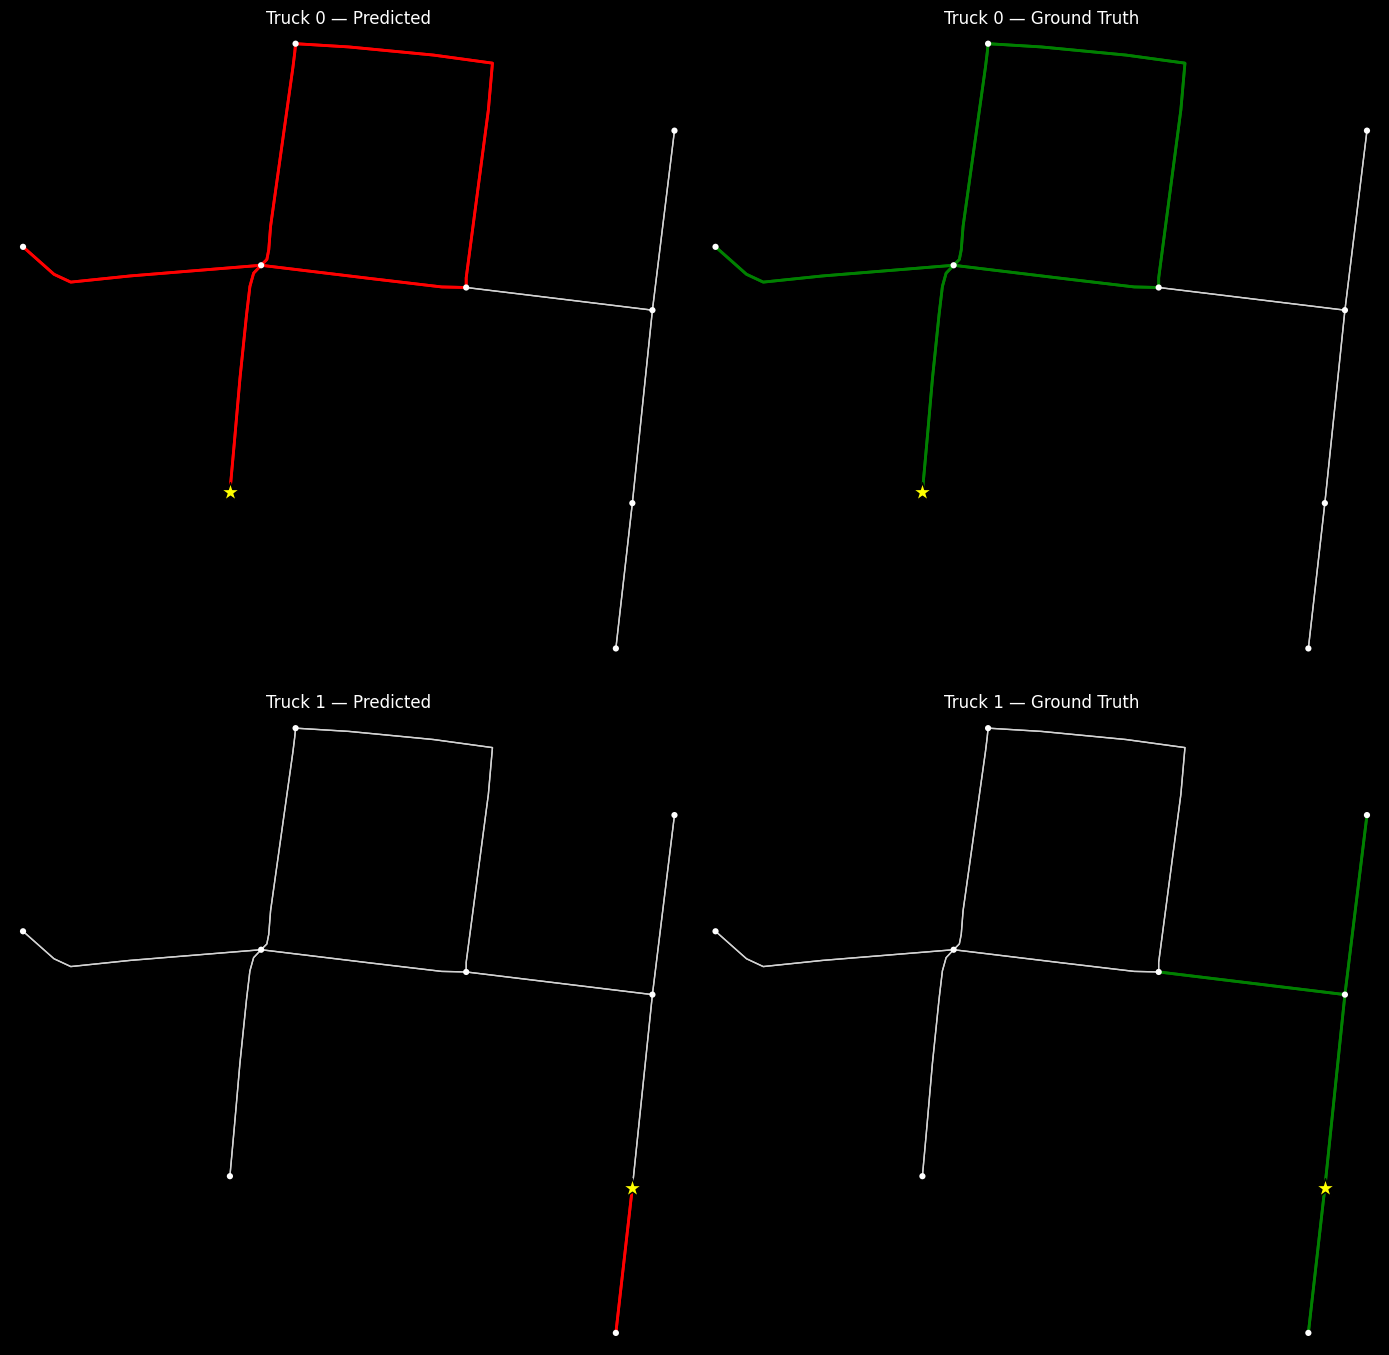

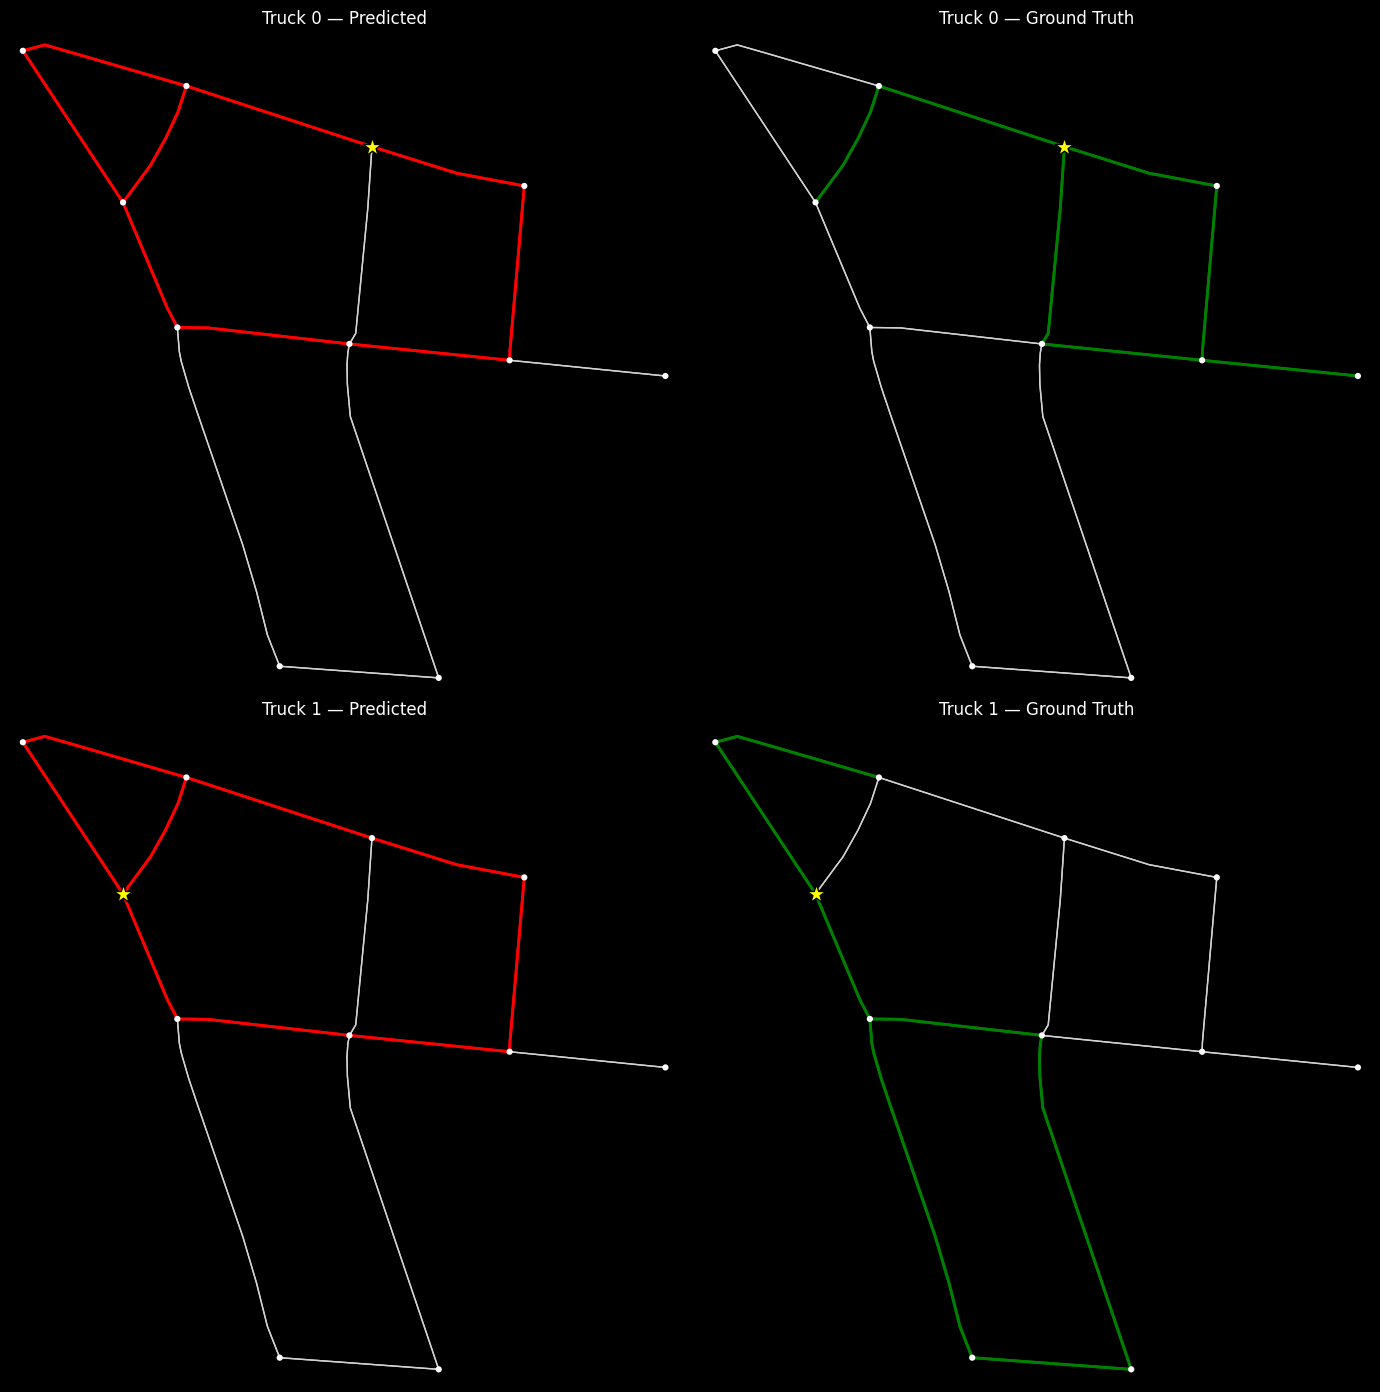

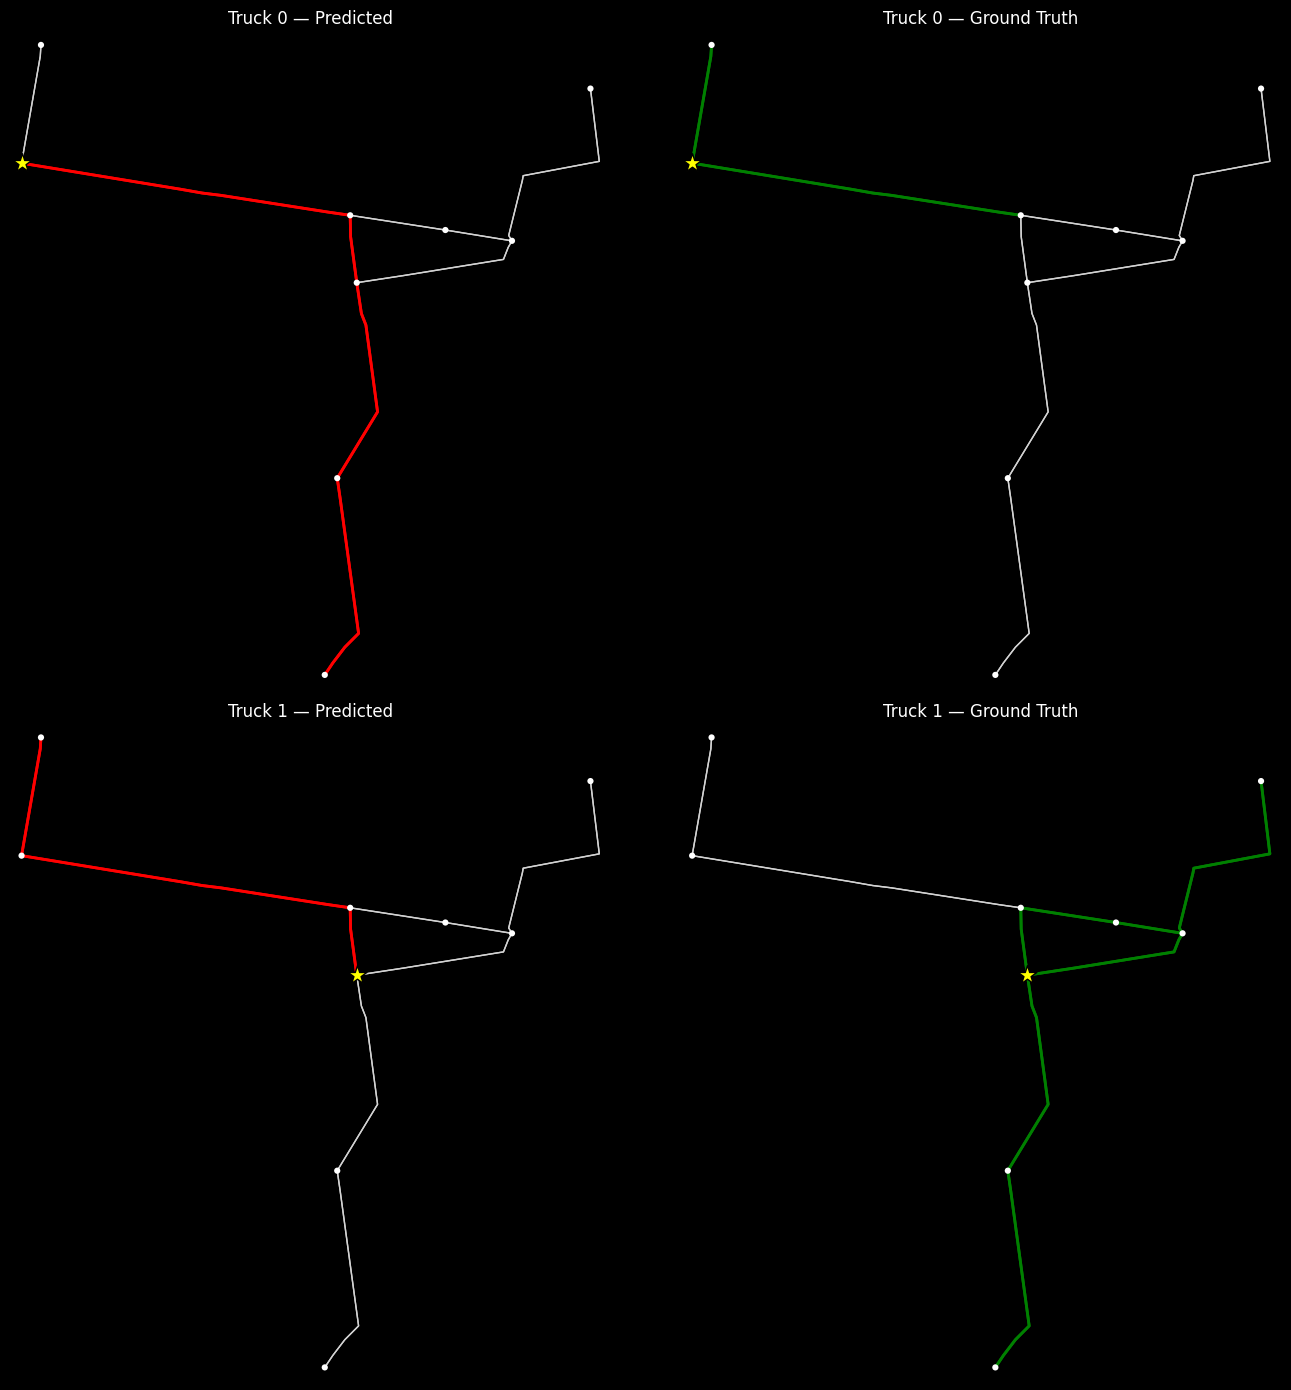

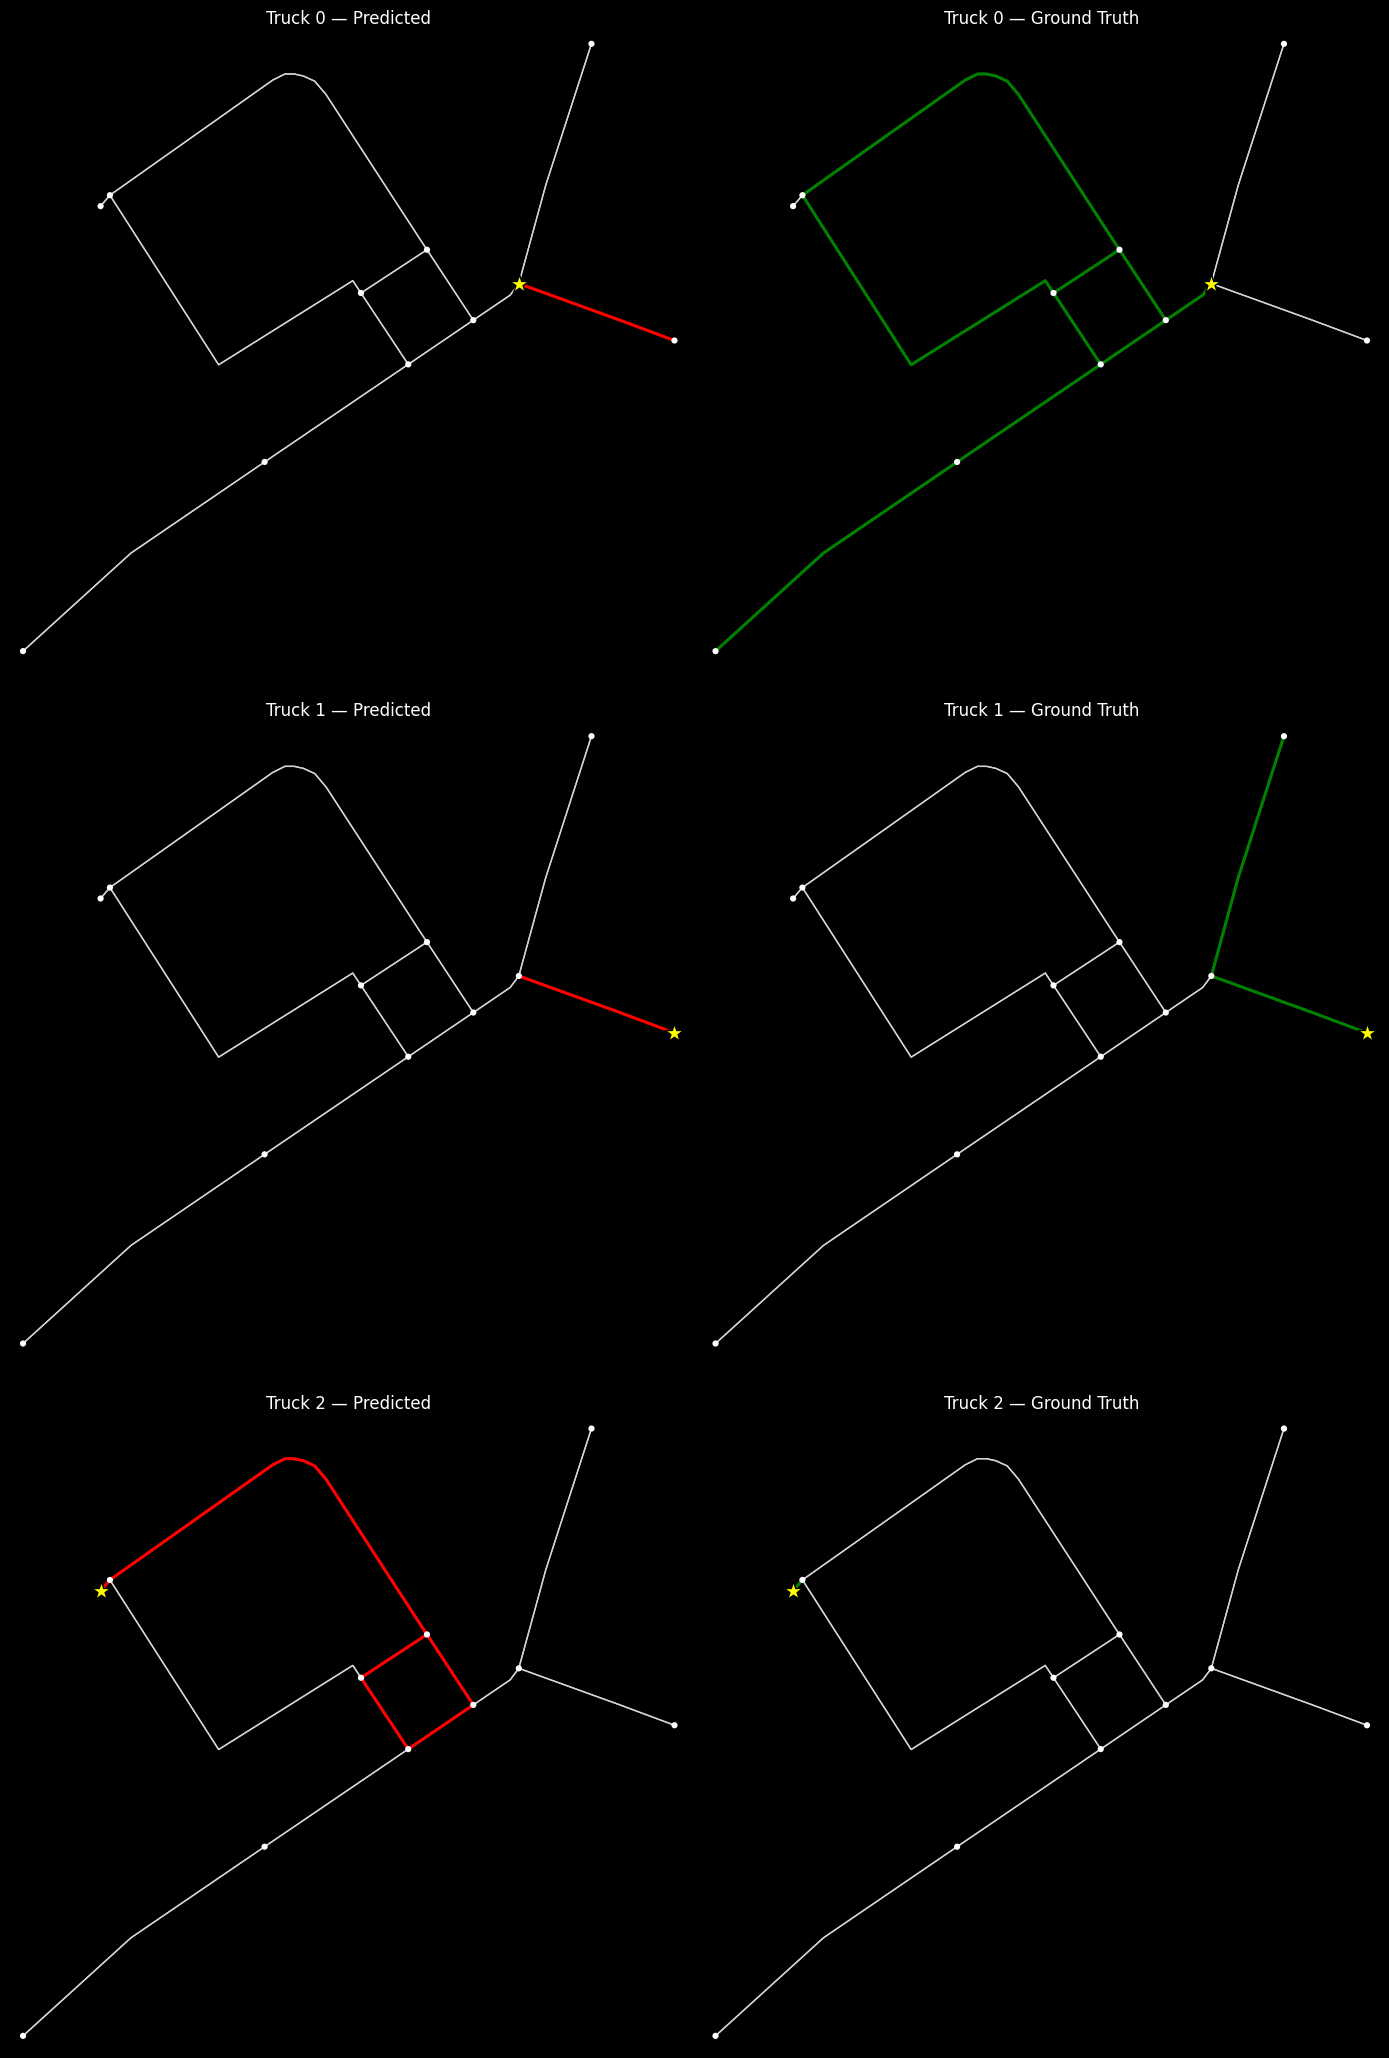

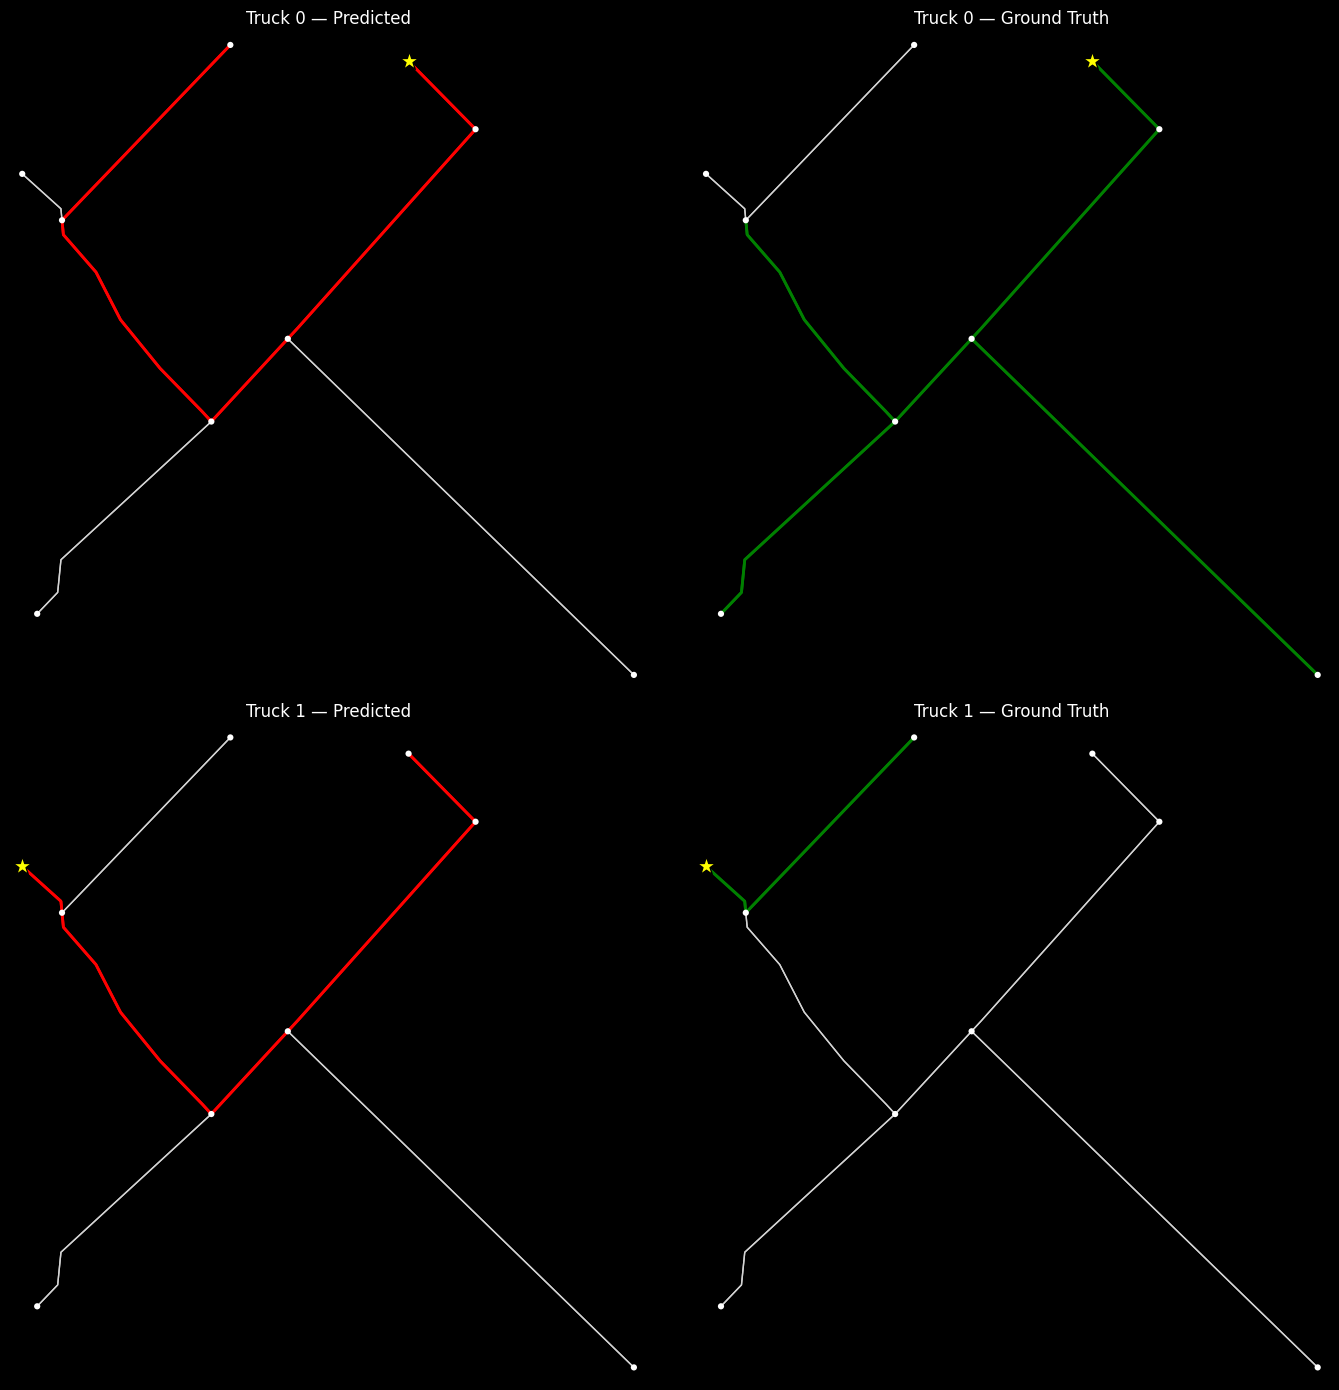

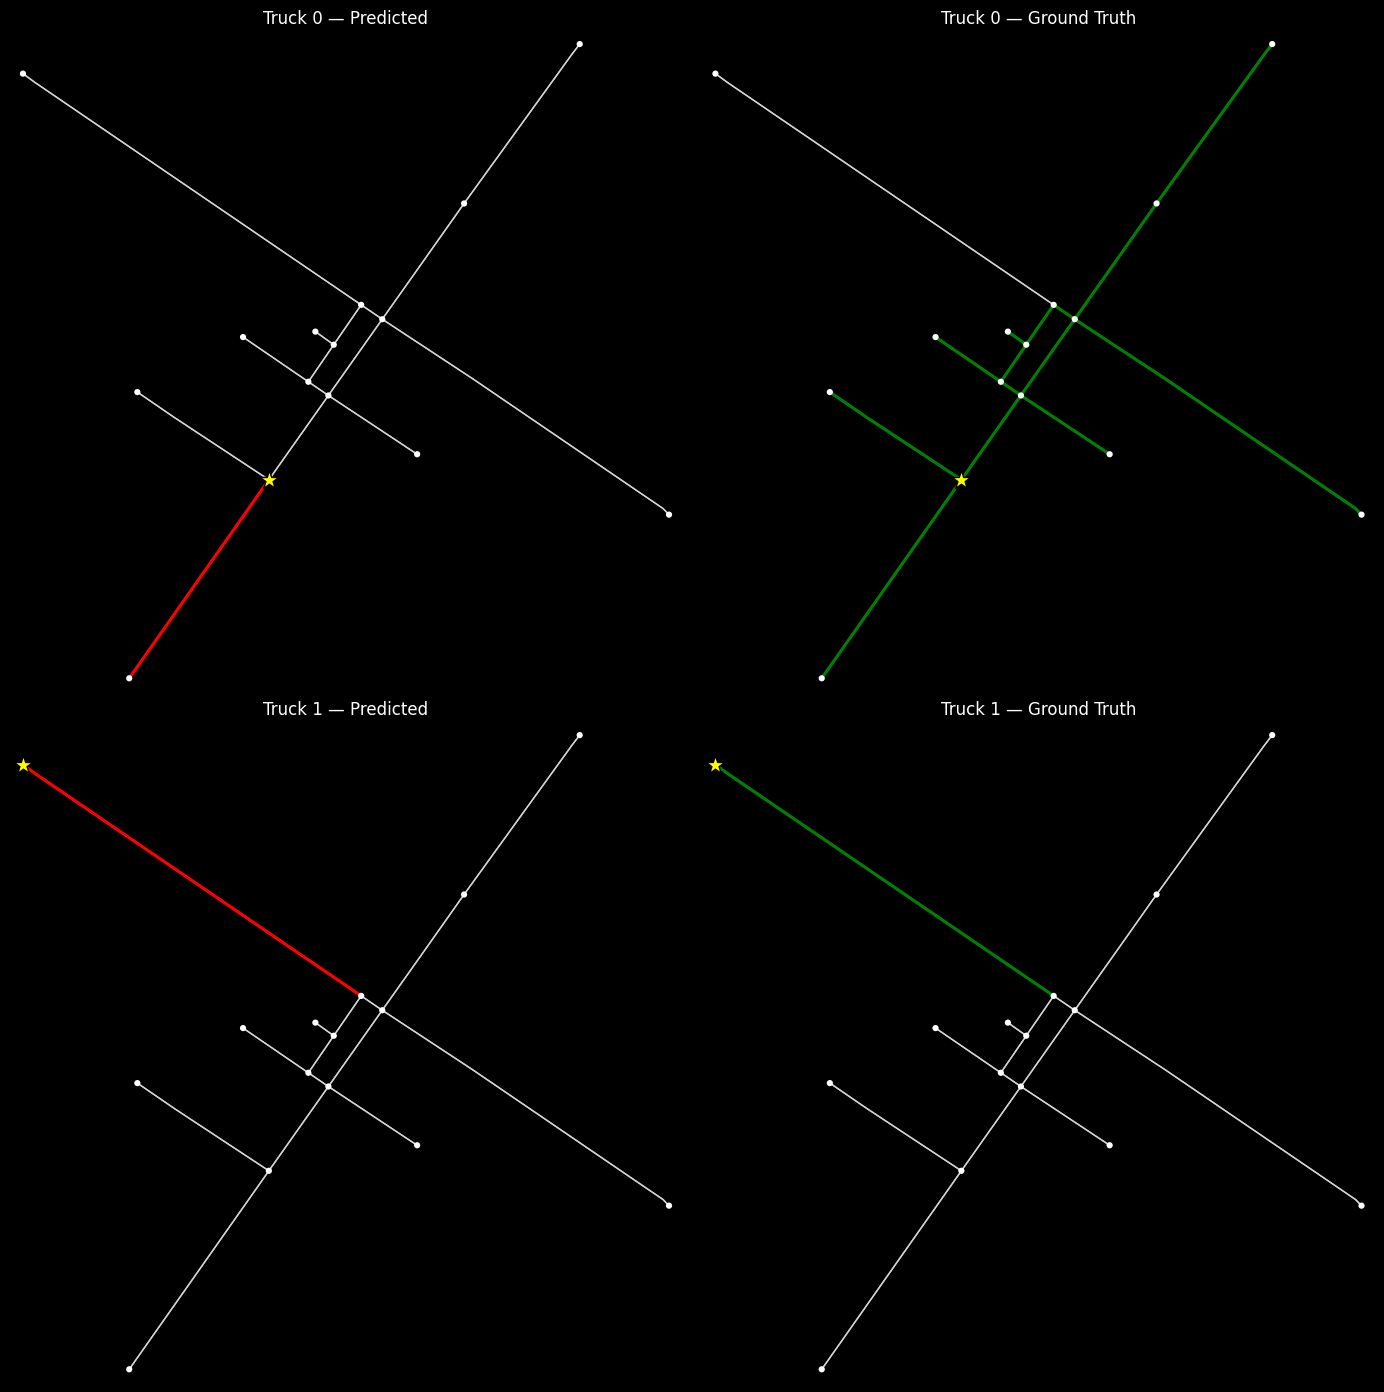

In [19]:
indices = [0, 2, 3, 4, 9, 97, 98, 104, 107]
for idx in indices:
    mod = "pred_routes"
    res   = all_results[idx]
    edges = res['list_edges']
    preds = res[mod]
    gts   = res['gt_routes']

    num_trucks = sum(1 for gt in gts if len(gt) > 0)
    sample     = test_loader.dataset[idx]
    raw        = sample['raw_list_nodes']
    deps       = sample['depot_indices'].tolist()
    depots     = { t: raw[d] for t, d in enumerate(deps) }

    pred_dict = { t: preds[t] for t in range(num_trucks) }
    gt_dict   = { t: gts[t]   for t in range(num_trucks) }

    # build an output filename
    out_fn = f"supervised_truck_routes_sample_{mod}_{idx}.png"

    # this will save the figure instead of only showing it
    plot_truck_routes_comparison(
        graph            = G,
        task_edges       = edges,
        pred_route_dict  = pred_dict,
        gt_route_dict    = gt_dict,
        depots           = depots,
        save_path        = out_fn
    )

In [ ]:
# def create_random_subgraph(G, radius=500, weight='length'):
#     """Pick a random center node and return a subgraph of nodes reachable within radius."""
#     nodes = list(G.nodes())
#     center_node = random.choice(nodes)
#     subgraph = ox.truncate.truncate_graph_dist(G, center_node, dist=radius, weight=weight)
#     return subgraph


# subgraph = create_random_subgraph(graph_tartu, radius=1000, weight='length')
# ox.plot_graph(subgraph, figsize=(6,6), node_size=5, edge_linewidth=0.5)

# # ————————————————
# # 2) pick 5 depots at random
# depots = random.sample(list(subgraph.nodes()), 5)   # e.g. [32891, 45213, …]

# # ————————————————
# # 3) build the “batch” and “line‐graph” tensors exactly as your DataLoader does

# # helper: your DataLoader’s graph→PyG‐batch routine
# def graph_to_batch_graph(G):
#     # returns a torch_geometric.data.Batch or similar
#     …  

# # helper: your DataLoader’s line‐graph routine
# def graph_to_line_graph_tensor(G):
#     # returns the LG tensor your assigner_line expects
#     …

# BG = graph_to_batch_graph(subgraph)                  # shape: (1, …)
# LG = graph_to_line_graph_tensor(subgraph)            # shape: (sum_E, M)

# # ————————————————
# # 4) run assigner + decoder (inference)
# with torch.no_grad():
#     # edge → truck assignment
#     lg_logits    = model.assigner_line(LG)           # (sum_E, M)
#     assigns_flat = lg_logits.argmax(dim=1)           # (sum_E,)
#     edge_assigns = [assigns_flat]                   # one‐sample batch

#     # encode
#     node_emb, global_emb, batch_vec = model.encoder(BG)

#     # decode (batch size = 1)
#     deps_tensor = torch.tensor([depots], dtype=torch.long)  # shape (1, M)
#     raw_nodes   = list(subgraph.nodes())
#     list_edges  = list(subgraph.edges())
#     routes_idx  = model.decoder(
#         global_emb,
#         node_emb,
#         batch_vec,
#         deps_tensor,
#         [raw_nodes],      # list of length 1
#         [list_edges],     # list of length 1
#         [subgraph],       # list of length 1
#         edge_assigns,
#         use_teacher_forcing=False
#     )

# # ————————————————
# # 5) convert index‐sequences → actual node‐ID routes
# pred_idx_seqs = routes_idx[0]  # this is a List[M] of index‐lists
# pred_routes   = [
#     [ raw_nodes[idx] for idx in seq ]
#     for seq in pred_idx_seqs
# ]

# # ————————————————
# # 6) build the dicts for visualization
# pred_dict = { t: pred_routes[t] for t in range(len(depots)) }
# dep_map   = { t: depots[t]       for t in range(len(depots)) }

# # ————————————————
# # 7) plot only the predicted routes (black background)
# plot_truck_routes_from_model(
#     graph=subgraph,
#     route_dict=pred_dict,
#     depots=dep_map
# )

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox

def plot_truck_routes_comparison(graph, task_edges,
                                 pred_route_dict,
                                 gt_route_dict,
                                 depots, save_path: str = None):
    """
    Visualize predicted vs. ground truth routes on the *subgraph* induced by task_edges,
    using OSMnx’s plot_graph with a true black background.

    Parameters
    ----------
    graph : networkx.Graph or MultiDiGraph
        The full OSMnx graph with node attributes 'x','y'.
    task_edges : list of (u,v)
        The edges defining which part of `graph` to extract.
    pred_route_dict : dict[int -> list of node IDs]
    gt_route_dict   : dict[int -> list of node IDs]
    depots : dict[int -> node ID]
    """
    # 1) Build node set and induce subgraph
    nodes = {u for (u, v) in task_edges} | {v for (u, v) in task_edges}
    G_sub = graph.subgraph(nodes).copy()

    # 2) Grab positions
    pos = {nid: (data['x'], data['y'])
           for nid, data in G_sub.nodes(data=True)}

    trucks = list(pred_route_dict.keys())
    if not trucks:
        print("No routes to plot.")
        return

    # 3) Create figure & axes
    rows, cols = len(trucks), 2
    fig, axes = plt.subplots(rows, cols,
                             figsize=(14, 7 * rows),
                             squeeze=False)
    # force the figure background to black
    fig.patch.set_facecolor('black')

    # 4) Loop over each truck
    for i, truck in enumerate(trucks):
        depot_node = depots.get(truck)

        # ---- Predicted panel ----
        ax_pred = axes[i][0]
        ax_pred.set_facecolor('black')

        # identify edges in this truck’s predicted route
        seq_pred = pred_route_dict[truck]
        service_pred = {frozenset((a, b)) for a, b in zip(seq_pred, seq_pred[1:])}

        # prepare colors & widths
        edge_colors, edge_widths = [], []
        for u, v, key, data in G_sub.edges(keys=True, data=True):
            if frozenset((u, v)) in service_pred:
                edge_colors.append('red')
                edge_widths.append(2.0)
            else:
                edge_colors.append('lightgray')
                edge_widths.append(1.0)

        # plot with OSMnx, forcing black background
        ox.plot_graph(G_sub, ax=ax_pred,
                      node_size=20,
                      edge_color=edge_colors,
                      edge_linewidth=edge_widths,
                      bgcolor='black',
                      show=False, close=False)

        # draw depot
        if depot_node in pos:
            ax_pred.scatter(*pos[depot_node],
                            marker='*', s=200,
                            c='yellow', edgecolors='black', zorder=5)

        ax_pred.set_title(f"Truck {truck} — Predicted", color='white')
        ax_pred.axis('off')

        # ---- Ground-truth panel ----
        ax_gt = axes[i][1]
        ax_gt.set_facecolor('black')

        seq_gt = gt_route_dict[truck]
        service_gt = {frozenset((a, b)) for a, b in zip(seq_gt, seq_gt[1:])}

        edge_colors, edge_widths = [], []
        for u, v, key, data in G_sub.edges(keys=True, data=True):
            if frozenset((u, v)) in service_gt:
                edge_colors.append('green')
                edge_widths.append(2.0)
            else:
                edge_colors.append('lightgray')
                edge_widths.append(1.0)

        ox.plot_graph(G_sub, ax=ax_gt,
                      node_size=20,
                      edge_color=edge_colors,
                      edge_linewidth=edge_widths,
                      bgcolor='black',
                      show=False, close=False)

        if depot_node in pos:
            ax_gt.scatter(*pos[depot_node],
                          marker='*', s=200,
                          c='yellow', edgecolors='black', zorder=5)

        ax_gt.set_title(f"Truck {truck} — Ground Truth", color='white')
        ax_gt.axis('off')

    plt.tight_layout()

    if save_path:
        # preserve the black background
        fig.savefig(save_path, facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)